In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from joblib import load

In [3]:
sns.set_theme(style="ticks", context="talk")
plt.rcParams.update({"axes.linewidth": 1.1, "xtick.major.size": 4, "ytick.major.size": 4})

In [4]:
X_background = pd.read_csv("../data_for_figures/X_train.csv")
y_background = X_background["label"]
X_background = X_background.drop(columns=["label"])

X_explain = pd.read_csv("../data_for_figures/X_val.csv")
y_explain = X_explain["label"]
X_explain = X_explain.drop(columns=["label"])

model = load("../generated_models/rf_model.joblib") 

In [5]:
feature_names = X_background.columns
feature_names = [value.replace("_", " ").capitalize().replace("Siga", "SIgA").replace("log", "(ug/mL, log)") for value in feature_names]
feature_names

['Gender',
 'SIgA average morning (ug/mL, log)',
 'SIgA average afternoon (ug/mL, log)',
 'SIgA average difference (ug/mL, log)']

In [6]:
feature_names = [
    'Gender',
    'SIgA average morning\n(ug/mL, log)',
    'SIgA average afternoon\n(ug/mL, log)',
    'SIgA average difference\n(ug/mL, log)'
]

In [7]:
explainer = shap.TreeExplainer(
    model,
    data=X_background,                 
    model_output="probability",        
    feature_perturbation="interventional"
)

shap_values = explainer(X_explain)

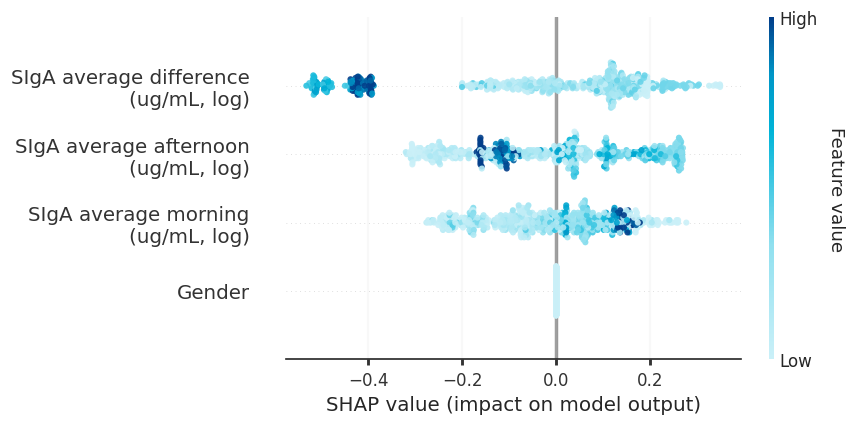

In [8]:
import shap, matplotlib.pyplot as plt, matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams.update({
    "figure.dpi": 110, "savefig.dpi": 300,
    "font.size": 11, "axes.labelsize": 12, "axes.titlesize": 13,
    "xtick.labelsize": 10, "ytick.labelsize": 10,
})

pandora_blues = LinearSegmentedColormap.from_list(
    "pandora_blues",
    ["#CAF0F8","#ADE8F4","#90E0EF","#48CAE4","#00B4D8","#0096C7","#023E8A"],
    N=256
)

shap.summary_plot(
    shap_values[..., 0],
    X_explain,
    feature_names=feature_names,
    plot_type="dot",
    max_display=10,
    show=False,
    color_bar=True,
    plot_size=(8, 4),
    cmap=pandora_blues,       
    alpha=0.9,                
)

fig = plt.gcf()
ax  = fig.axes[0]         
cax = fig.axes[1]         

for coll in ax.collections:
    if isinstance(coll, mpl.collections.PathCollection):
        coll.set_cmap(pandora_blues)

ax.grid(True, axis="x", alpha=0.12)
ax.set_xlabel("SHAP value (impact on model output)")
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)

cax.set_ylabel("Feature value", rotation=270, labelpad=18)

plt.tight_layout()
plt.savefig("../tmp_figures/shap_summary_beeswarm.svg", bbox_inches="tight", dpi=300, transparent=True)
plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.base import clone

# Paleta
FEDERAL_BLUE   = "#03045e"   # diagonal (azar)
MARIAN_BLUE    = "#023e8a"   # curva media
HONOLULU_BLUE  = "#0077b6"   # curvas de folds
NONPHOTO_BLUE2 = "#ade8f4"   # banda ±1 SD

def create_curve_roc_cv_pretty(
    clf_model,
    X, y,
    n_splits=6,
    random_state=42,
    pos_label=None,
    title="Mean ROC curve with variability",
    figsize=(7.5, 4),       # <-- más ancho
    fontsize=11,            # <-- textos más pequeños
    legend_outside=False,    # <-- leyenda a la derecha
):
    fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    mean_fpr = np.linspace(0, 1, 100)
    tprs, aucs = [], []

    # Curvas por fold
    for fold, (tr, te) in enumerate(cv.split(X, y), 1):
        model = clone(clf_model)
        model.fit(X[tr], y[tr])
        disp = RocCurveDisplay.from_estimator(
            model, X[te], y[te],
            name=f"Fold {fold}",
            ax=ax, alpha=0.25, lw=1.25,
            color=HONOLULU_BLUE, pos_label=pos_label,
        )
        interp_tpr = np.interp(mean_fpr, disp.fpr, disp.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(disp.roc_auc)

    # Curva media
    mean_tpr = np.mean(tprs, axis=0); mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr); std_auc = np.std(aucs)

    ax.plot(mean_fpr, mean_tpr,
            color=MARIAN_BLUE, lw=2.6,
            label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})")

    # Banda ±1 SD
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper,
                    color=NONPHOTO_BLUE2, alpha=0.35, lw=0, label="±1 SD")

    # Línea de azar
    ax.plot([0, 1], [0, 1], ls="--", color=FEDERAL_BLUE, alpha=0.5, lw=1)

    # Estética sobria
    ax.set(xlim=(0, 1), ylim=(0, 1.02),
           xlabel="False Positive Rate", ylabel="True Positive Rate",
           title=title)
    ax.grid(True, alpha=0.15)
    for s in ("top", "right"): ax.spines[s].set_visible(False)

    # Ticks y fuentes más pequeñas
    ax.tick_params(labelsize=fontsize)
    ax.title.set_fontsize(fontsize+2)
    ax.xaxis.label.set_fontsize(fontsize+1)
    ax.yaxis.label.set_fontsize(fontsize+1)

    # Leyenda a la derecha (fuera del eje)
    if legend_outside:
        ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
                  frameon=False, fontsize=fontsize)
        # deja margen a la derecha para la leyenda
        plt.subplots_adjust(right=0.78)
    else:
        ax.legend(loc="lower right", frameon=False, fontsize=fontsize)

    fig.savefig("../tmp_figures/roc_curve.svg", bbox_inches="tight", dpi=300, transparent=True)

    return fig, ax, {"mean_auc": mean_auc, "std_auc": std_auc, "fold_aucs": aucs}


(<Figure size 825x440 with 1 Axes>,
 <Axes: title={'center': 'Mean ROC curve with variability'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 {'mean_auc': np.float64(0.9765888112043414),
  'std_auc': np.float64(0.00904336728936925),
  'fold_aucs': [np.float64(0.9589086127547666),
   np.float64(0.9841843816202791),
   np.float64(0.9840848806366048),
   np.float64(0.9806218685529031),
   np.float64(0.9843059239610964),
   np.float64(0.9809165929855584)]})

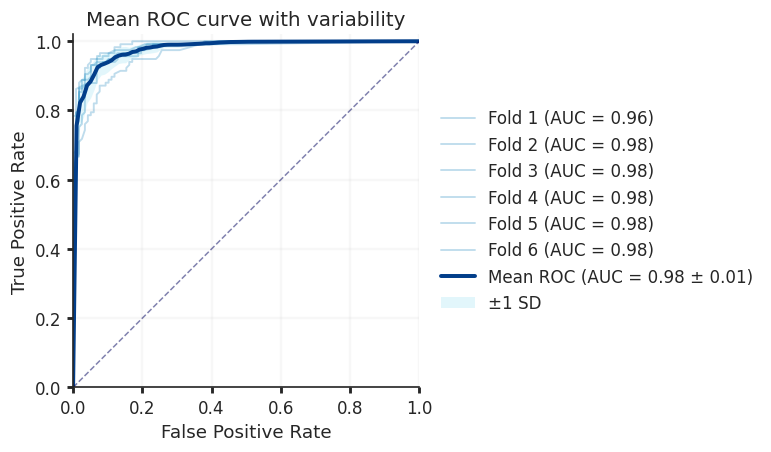

In [10]:
create_curve_roc_cv_pretty(
    model,
    X_background.values,
    y_background.values,
    n_splits=6,
    random_state=42,
    title="Mean ROC curve with variability",
    pos_label=None,   
    legend_outside=True              
)